In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [2]:
sc._settings.ScanpyConfig.n_jobs = -1

In [3]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [19]:
df = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/tonsil_CODEX2/quantification/Lymphoid_Data.csv')

In [17]:
df['sample'].unique()

array(['tonsil9338', 'tonsil6677', 'tonsil8953', 'LN', 'spleen'],
      dtype=object)

In [14]:
df.iloc[:,-11:]

,x,y,max_x,max_y,file_key,x_in_file,y_in_file,follicle_id,Cluster Number,Cluster class,Cluster name
0,0.000473,0.083803,14784,19152,tonsil9338,7.0,1605.0,NO_LABEL_ASSIGNED,1,B cells,B cells - (CD19/CD22/CD40)
1,0.005208,0.086623,14784,19152,tonsil9338,77.0,1659.0,NO_LABEL_ASSIGNED,1,B cells,B cells - (CD19/CD22/CD40)
2,0.000812,0.104010,14784,19152,tonsil9338,12.0,1992.0,NO_LABEL_ASSIGNED,1,B cells,B cells - (CD19/CD22/CD40)
3,0.005817,0.089129,14784,19152,tonsil9338,86.0,1707.0,NO_LABEL_ASSIGNED,1,B cells,B cells - (CD19/CD22/CD40)
4,0.008387,0.087510,14784,19152,tonsil9338,124.0,1676.0,NO_LABEL_ASSIGNED,1,B cells,B cells - (CD19/CD22/CD40)
...,...,...,...,...,...,...,...,...,...,...,...
2330398,0.874504,0.232876,20160,23184,spleen,17630.0,5399.0,NO_LABEL_ASSIGNED,31,unique,Vimentin positive cells (CD45-)
2330399,0.917659,0.632074,20160,23184,spleen,18500.0,14654.0,NO_LABEL_ASSIGNED,31,unique,Vimentin positive cells (CD45-)
2330400,0.938442,0.108696,20160,23184,spleen,18919.0,2520.0,NO_LABEL_ASSIGNED,31,unique,Vimentin positive cells (CD45-)
2330401,0.935714,0.569876,20160,23184,spleen,18864.0,13212.0,NO_LABEL_ASSIGNED,31,unique,Vimentin positive cells (CD45-)


In [20]:
df.drop(columns=['ProfileID', 'ClusterID', ':cell_id.cell_id', ':tile_nr.tile_nr', ':X.X', ':Y.Y', ':Z.Z', 'x', 'y', 
                 'max_x', 'max_y', 'sample', 'follicle_id', 'Cluster Number', 'Cluster class'], inplace=True)
df.rename(columns={'Cluster name': 'cell_type'}, inplace=True)
df = reorder_columns(df, ':size.size', ':Cyc_1_ch_1.HOECHST1')
df.rename(columns={'x_in_file': 'x', 'y_in_file': 'y'}, inplace=True)

In [21]:
df.rename(columns=lambda x: x.split('.')[-1] if x.startswith(':Cyc') else x, inplace=True)

In [22]:
df.columns

Index(['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8', 'Cd90',
       'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'Cytokeratin', 'CD2', 'CD66',
       'CollagenIV', 'Cd81', 'HLADR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IgM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD27', 'CD104', 'CD273', 'HOECHST1', ':size.size', 'file_key',
       'x', 'y', 'cell_type'],
      dtype='object')

In [23]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/tonsil_CODEX2/quantification/processed/Lymphoid_Data_cleaned.csv', index=False)

In [40]:
df.drop(columns=['HOECHST1'], inplace=True)

KeyError: "['HOECHST1'] not found in axis"

In [41]:
X_columns = df.columns[:df.columns.get_loc(':size.size')]
obs_columns = df.columns[df.columns.get_loc(':size.size'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [42]:
adata.X.max()

65536.0

In [43]:
adata.raw = adata
adata.X = np.arcsinh(adata.X/150)
adata.layers['zscore'] = z_score_normalization(adata.X)

In [25]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


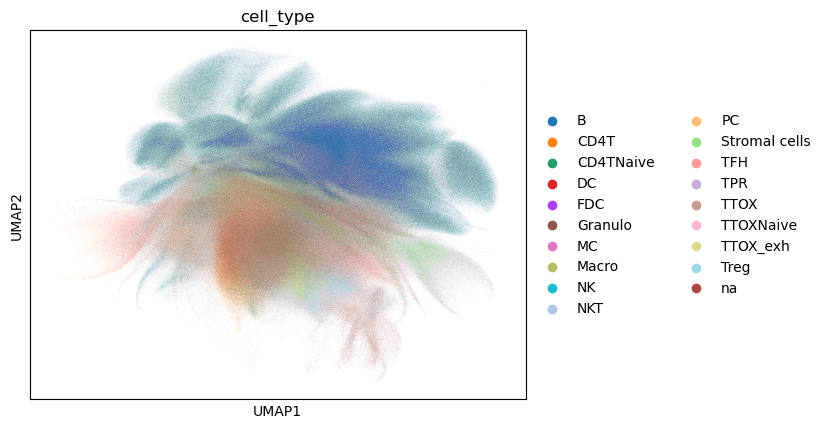

In [18]:
sc.pl.umap(adata, color='cell_type')

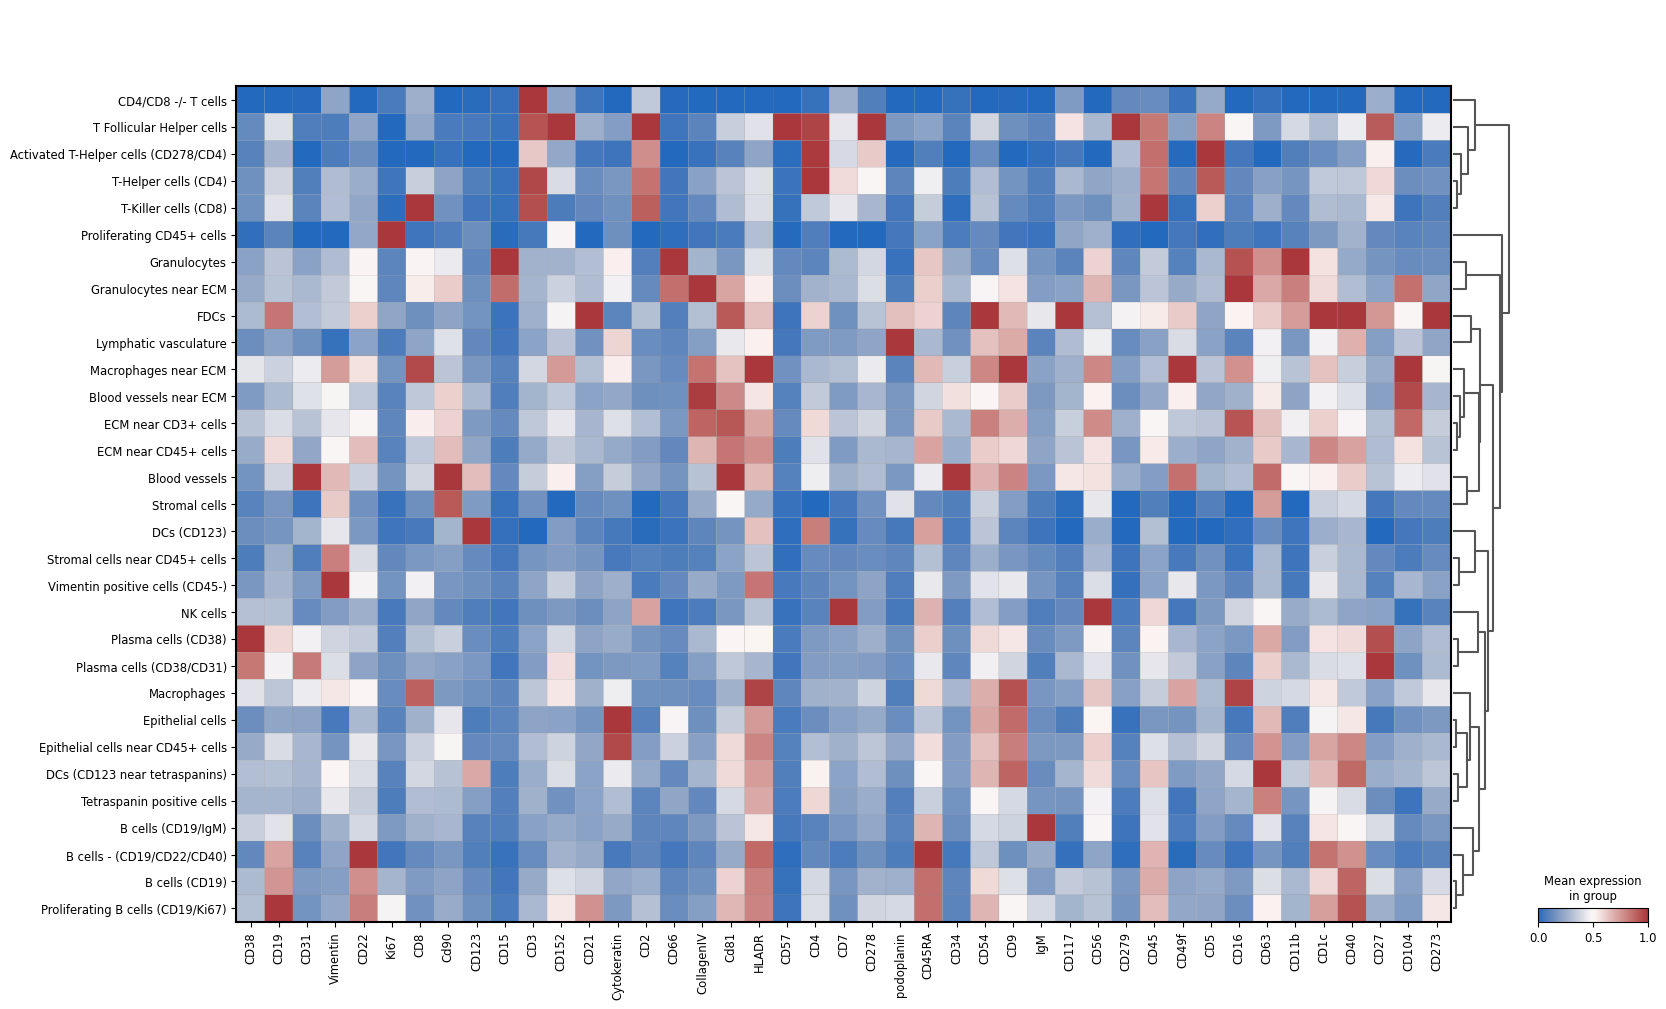

In [45]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False, standard_scale='var')

TFh activated cells based on loss of CTLA4 and PD1? Proliferating CD45 cells not really positive fro CD45, maybe rename. Macrophages definition not really robust. DCs are probably pDCs. Often only because of low/medium exoression of a marker that is not associated to a cell type (prior knowledge based), they call them near to? 

In [46]:
sc.tl.rank_genes_groups(adata, groupby='cell_type' , method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.2, max_out_group_fraction = 1, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups

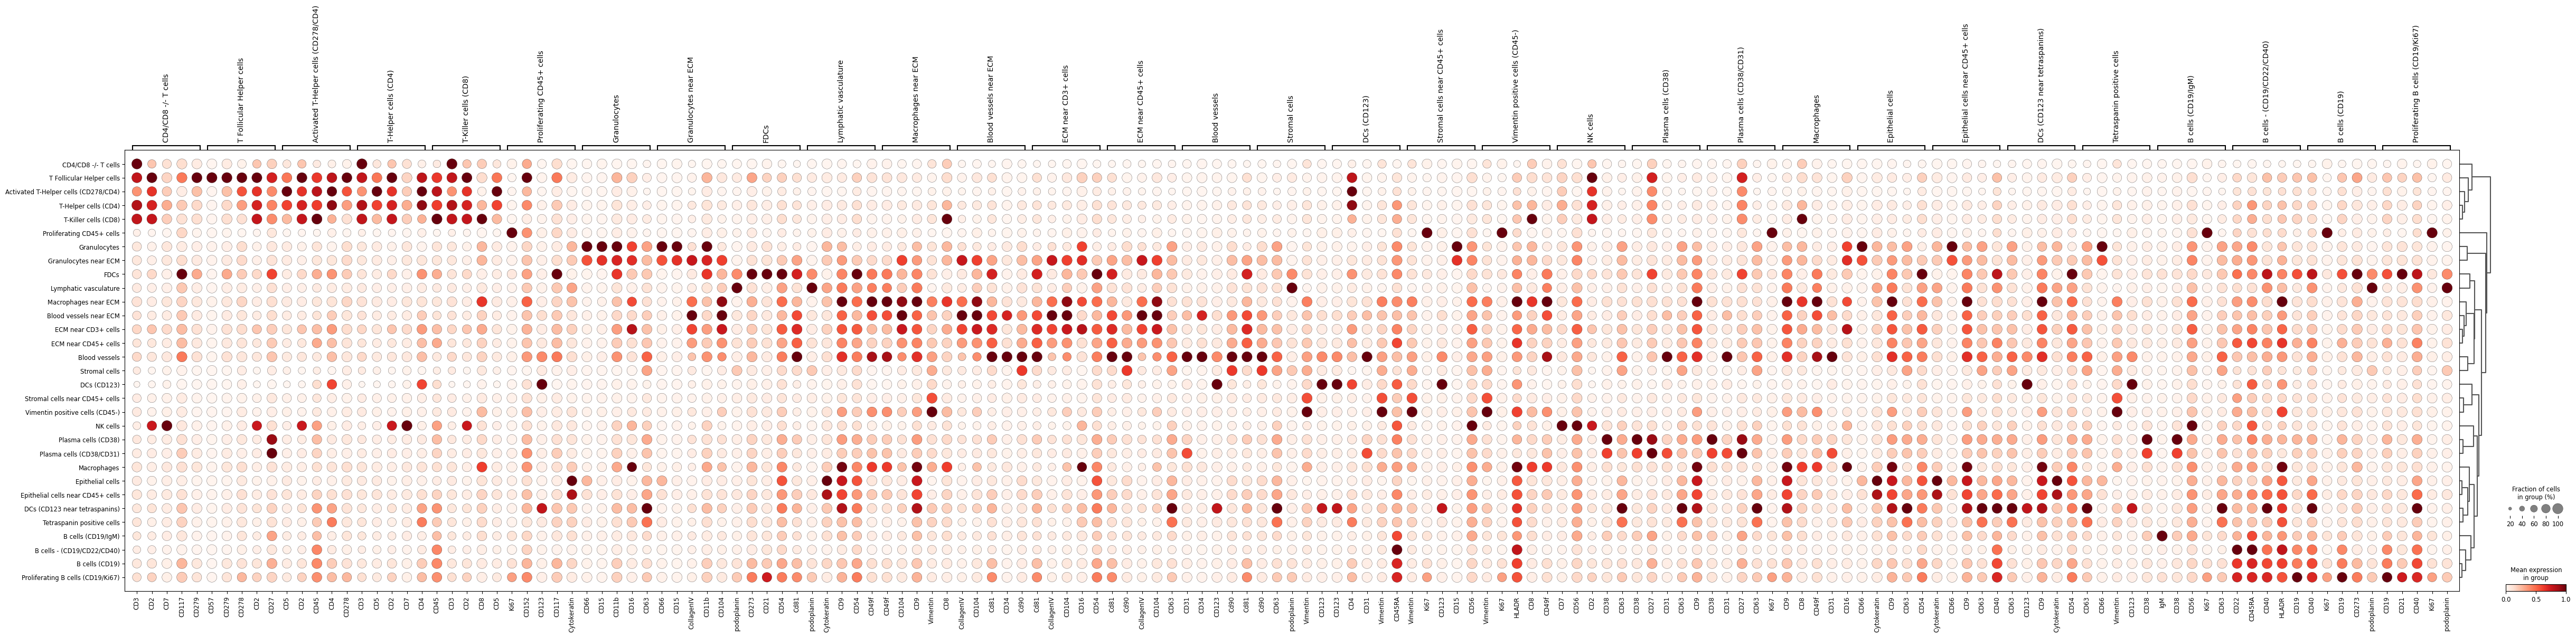

In [47]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups')

categories: Activated T-Helper cells (CD278/CD4), B cells (CD19), B cells (CD19/IgM), etc.
var_group_labels: 


ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (0,)

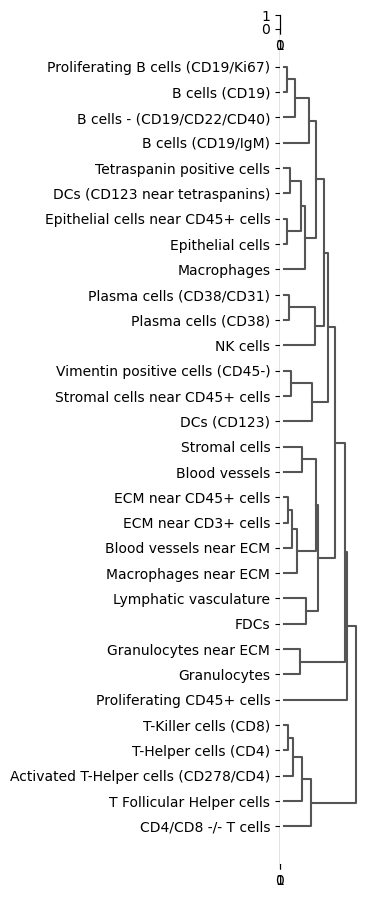

In [48]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')